# Fake News Detection: What NLP tools available can help us tackle this issue?

## Introduction

The rise of fake news and propaganda has sparked numerous research efforts to address the problem using machine learning. Some researchers concentrate on Deep Learning techniques, while others opt for a more hands-on approach. As stated in [this study](https://www.hindawi.com/journals/complexity/2021/5557784/), a numerous researches have have proven the significance of the CNN and deep learning models for classification of fake news, however there is still a room for improvement. It is also found that LIAR dataset is one of the widely used benchmark dataset for the detection of fake news.

This research project concentrates mainly on the feature engineering. Our goal is to create features that can be leveraged for training neural networks, effectively bridging the gap between manual methods and automated Deep Learning techniques.

NLP project plan:

1. Data Acquisition ✅
2. EDA ✅ 
3. Text Processing ✅
4. Feature Engineering
   - TF-IDF with ensamble method
   - NER
   - Embeddings (one hot encoding)
   - N-grams
   - Word2Vec
   - not SVM /LDA!1  
5. Feature Extraction
   - Chi2
6. Further work (model building)
7. Conclusions

Before jumping to the code, let us import all the tools necessary for this project.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import spacy

from gensim.models import Word2Vec

import re
from num2words import num2words

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

## 1. Data Acquisition

In this project we will be using [LIAR](https://paperswithcode.com/dataset/liar) dataset. We have downloaded the resources into the `dataset` folder, so now we can load the data into `pandas` data frame.

In [25]:
liar_df = pd.read_csv("dataset/train.tsv", sep='\t', header=None)

According to the documentation, the dataset has the following columns:

    Column 1: the ID of the statement ([ID].json).
    Column 2: the label.
    Column 3: the statement.
    Column 4: the subject(s).
    Column 5: the speaker.
    Column 6: the speaker's job title.
    Column 7: the state info.
    Column 8: the party affiliation.
    Column 9-13: the total credit history count, including the current statement.
    9: barely true counts.
    10: false counts.
    11: half true counts.
    12: mostly true counts.
    13: pants on fire counts.
    Column 14: the context (venue / location of the speech or statement).

We can define a `column_names` variable to store them and introduce them as headers into our data frame.

In [47]:
column_names = ['Statement ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker\'s job title', 'State', 'Party affiliation', 'Barely true', 'False', 'Half true', 'Mostly true', 'Pants on fire', 'Statement context']
liar_df.columns = column_names

liar_df.head()

,Statement ID,Label,Statement,Subject,Speaker,Speaker's job title,State,Party affiliation,Barely true,False,Half true,Mostly true,Pants on fire,Statement context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [56]:
liar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Statement ID         10240 non-null  object 
 1   Label                10240 non-null  object 
 2   Statement            10240 non-null  object 
 3   Subject              10238 non-null  object 
 4   Speaker              10238 non-null  object 
 5   Speaker's job title  7342 non-null   object 
 6   State                8030 non-null   object 
 7   Party affiliation    10238 non-null  object 
 8   Barely true          10238 non-null  float64
 9   False                10238 non-null  float64
 10  Half true            10238 non-null  float64
 11  Mostly true          10238 non-null  float64
 12  Pants on fire        10238 non-null  float64
 13  Statement context    10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


Before manipulating the data, let us make sure that we don't have any missing values that is important to us, like statements and scores. As seen in the `head()` output, there are some missing values in `Speaker's job title`, `State` and `Party affiliation` columns, but that is less important data for our analysis.

In [30]:
def check_column_values(df, columns_to_check):
    nan_check = df[columns_to_check].isna().any()
    empty_string_check = (df[columns_to_check] == '').any()
    none_check = pd.isna(df[columns_to_check]).any()
    
    result = {
        'NaN Check': nan_check,
        'Empty String Check': empty_string_check,
        'None Check': none_check
    }

    return result

In [48]:
check_column_values(liar_df, ['Label', 'Statement', 'Subject', 'Barely true', 'False', 'Half true', 'Mostly true', 'Pants on fire'])

{'NaN Check': Label            False
 Statement        False
 Subject           True
 Barely true       True
 False             True
 Half true         True
 Mostly true       True
 Pants on fire     True
 dtype: bool,
 'Empty String Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'None Check': Label            False
 Statement        False
 Subject           True
 Barely true       True
 False             True
 Half true         True
 Mostly true       True
 Pants on fire     True
 dtype: bool}

It looks like we do have missing values in numerous columns, let us explore them more.

In [49]:
subj_na = liar_df[liar_df['Subject'].isna()]
subj_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 2142 to 9375
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Statement ID         2 non-null      object 
 1   Label                2 non-null      object 
 2   Statement            2 non-null      object 
 3   Subject              0 non-null      object 
 4   Speaker              0 non-null      object 
 5   Speaker's job title  0 non-null      object 
 6   State                0 non-null      object 
 7   Party affiliation    0 non-null      object 
 8   Barely true          0 non-null      float64
 9   False                0 non-null      float64
 10  Half true            0 non-null      float64
 11  Mostly true          0 non-null      float64
 12  Pants on fire        0 non-null      float64
 13  Statement context    0 non-null      object 
dtypes: float64(5), object(9)
memory usage: 240.0+ bytes


In [51]:
subj_na.loc[2142, 'Statement']

'The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.\'\'\tabortion\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\ta TV interview with megachurch pastor Rick Warren in Lake Forest, Calif.\n2724.json\ttrue\tMost of the jobs that we lost were lost before the economic policies we put in place had any effect.\teconomy,job-accomplishments,jobs,stimulus\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\tan interview on The Daily Show with Jon Stewart"'

It looks like we do have all the information, however it wasn't parsed correctly. If we look into the raw dataset - here's how this particular row looks like:

`638.json	false	"The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.''	abortion	barack-obama	President	Illinois	democrat	70	71	160	163	9	a TV interview with megachurch pastor Rick Warren in Lake Forest, Calif.`

The issue is with the incorrect quotation marks, which confused `pandas`. Let us try to fix that.

In [39]:
result_list = re.split(r'(?<!\')\t', subj_na.loc[2142, 'Statement'])

# Remove any remaining single quotes around the first and last elements
result_list[0] = result_list[0].lstrip('\'')
result_list[-1] = result_list[-1].rstrip('\'')

print(result_list)

["The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.''\tabortion", 'barack-obama', 'President', 'Illinois', 'democrat', '70', '71', '160', '163', '9', 'a TV interview with megachurch pastor Rick Warren in Lake Forest, Calif.\n2724.json', 'true', 'Most of the jobs that we lost were lost before the economic policies we put in place had any effect.', 'economy,job-accomplishments,jobs,stimulus', 'barack-obama', 'President', 'Illinois', 'democrat', '70', '71', '160', '163', '9', 'an interview on The Daily Show with Jon Stewart"']


Instead of cleaning the document line by line we could remove all the punctuation before feeding it to `pandas`. We will define two functions for that.

In [38]:
def remove_punctuation(text):
    words = word_tokenize(text)
    words_without_punct = [word for word in words if word not in punctuation]
    clean_text = ' '.join(words_without_punct)
    
    return clean_text

def process_tsv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f_in:
        with open(output_file, 'w', encoding='utf-8') as f_out:
            for line in f_in:
                fields = line.strip().split('\t')
                clean_fields = [remove_punctuation(field) for field in fields]
                f_out.write('\t'.join(clean_fields) + '\n')

Now let us try to process our train.tsv file.

In [23]:
input_file = "dataset/train.tsv"
output_file = "dataset/train-cleaned.tsv"

process_tsv(input_file, output_file)

We can re-load the dataset into the data frame and see if it's any better after cleaning.

In [5]:
liar_df = pd.read_csv("dataset/train-cleaned.tsv", sep='\t', header=None)
liar_df.columns = column_names
liar_df.head()

,Statement ID,Label,Statement,Subject,Speaker,Speaker's job title,State,Party affiliation,Barely true,False,Half true,Mostly true,Pants on fire,Statement context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,10540.json,half-true,When did the decline of coal start It started ...,energy history job-accomplishments,scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech
2,324.json,mostly-true,Hillary Clinton agrees with John McCain `` by ...,foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7,19,3,5,44,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,economy jobs,charlie-crist,NaN,Florida,democrat,15,9,20,19,2,an interview on CNN


Let us check column values and the problematic row we had before.

In [28]:
liar_df.loc[2154]

Statement ID                                                    638.json
Label                                                              false
Statement              `` The fact is that although we have had a pre...
Subject                                                         abortion
Speaker                                                     barack-obama
Speaker's job title                                            President
State                                                           Illinois
Party affiliation                                               democrat
Barely true                                                           70
False                                                                 71
Half true                                                            160
Mostly true                                                          163
Pants on fire                                                          9
Statement context      a TV interview with megachur

In [31]:
check_column_values(liar_df, ['Label', 'Statement', 'Subject', 'Barely true', 'False', 'Half true', 'Mostly true', 'Pants on fire'])

{'NaN Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'Empty String Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'None Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool}

In [32]:
subj_na = liar_df[liar_df['Subject'].isna()]
subj_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Statement ID         0 non-null      object
 1   Label                0 non-null      object
 2   Statement            0 non-null      object
 3   Subject              0 non-null      object
 4   Speaker              0 non-null      object
 5   Speaker's job title  0 non-null      object
 6   State                0 non-null      object
 7   Party affiliation    0 non-null      object
 8   Barely true          0 non-null      int64 
 9   False                0 non-null      int64 
 10  Half true            0 non-null      int64 
 11  Mostly true          0 non-null      int64 
 12  Pants on fire        0 non-null      int64 
 13  Statement context    0 non-null      object
dtypes: int64(5), object(9)
memory usage: 0.0+ bytes


Looks like we have all the data we need, however, there are still small artifacts left, like in the row 2154 we have redundant `` marks. We will address this issue in the Text processing section.

## 2. Simple Data Exploratory Analysis

Before diving into feature extraction and model training, it's crucial to start with exploratory data analysis (EDA). EDA helps us get familiar with the dataset's characteristics, ensuring we make informed decisions later on. First of all, we'll look at the balance of the labels we have in our dataset. If some categories are much more common than others, our model might end up biased, good at recognizing the common ones and bad at spotting the rare ones. After labels, we'll check out the text itself. How long are the pieces? Are fake news articles longer or shorter than true ones, or is there no simple pattern? The visualizations below will provide us with some answers.

First of all, tet us explore what labels we have in our dataset.

In [6]:
labels = liar_df['Label'].unique()
print(labels)

['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


We will build a couple of plots to visualize the distribution of text across the categories, word count distribution and word count by category.

In [8]:
def plot_category_distribution(df, category_column):
    """
    Plots the distribution of texts across different categories.

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - category_column: the name of the column containing the category labels.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(y=category_column, data=df, order = df[category_column].value_counts().index)
    plt.title('Distribution of Text Across Categories')
    plt.xlabel('Number of Texts')
    plt.ylabel('Categories')
    plt.show()

def plot_word_count_distribution(df, text_column):
    """
    Plots the distribution of word counts in the texts.

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - text_column: the name of the column containing the text data.
    """
    df['word_count'] = df[text_column].apply(lambda x: len(str(x).split()))
    
    plt.figure(figsize=(12, 6))
    sns.histplot(df['word_count'], bins=50, kde=True)
    plt.title('Word Count Distribution in Texts')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()

def plot_word_count_by_category(df, text_column, category_column):
    """
    Plots the distribution of word counts in texts across different categories.

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - text_column: the name of the column containing the text data.
    - category_column: the name of the column containing the category labels.
    """
    df['word_count'] = df[text_column].apply(lambda x: len(str(x).split()))
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='word_count', y=category_column, data=df)
    plt.title('Word Count Distribution by Category')
    plt.xlabel('Word Count')
    plt.ylabel('Category')
    plt.show()


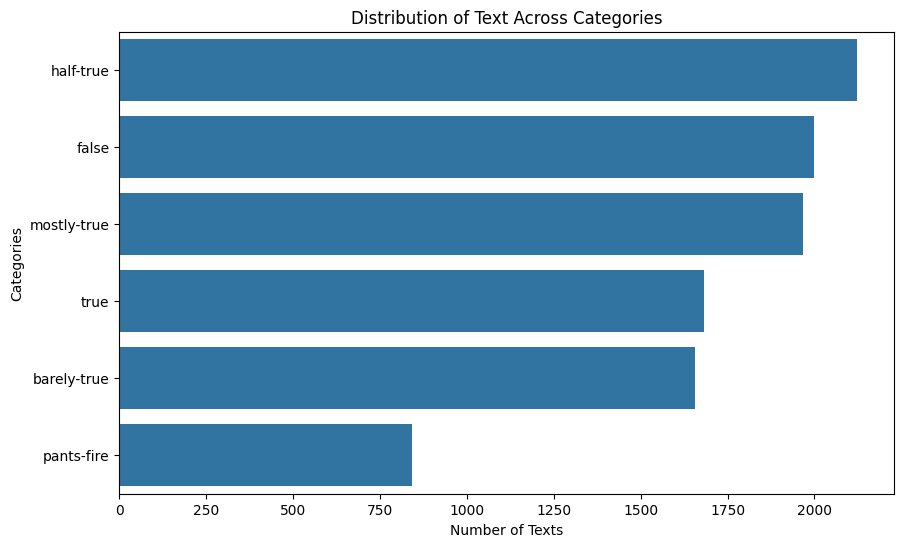

In [9]:
plot_category_distribution(liar_df, "Label")

Based on the plot above, we can make the following observations:

1. **Category Imbalance**: The first observation is that there is a noticeable imbalance in the dataset across the different truthfulness categories. This is evident by the varying bar lengths, indicating the number of texts in each category.

2. **Most Common Categories**: The categories "half-true" and "mostly-true" have the highest number of texts, which suggests that the dataset contains a significant number of claims that are not entirely false or true but fall somewhere in between.

3. **Least Common Category**: The "pants-fire" category, which likely represents the most extreme level of falsehood, has the fewest texts. This could indicate that outright fabrications or extreme falsehoods are less common in the dataset, or possibly that they are less frequently identified and labeled as such.

4. **Potential Bias in Training**: Given the imbalance, a machine learning model trained on this dataset may develop a bias toward the more frequently occurring categories. It's important to consider techniques like oversampling, undersampling, or synthetic data generation to address this imbalance.

5. **Labeling Considerations**: The distribution suggests that labeling news as "true" or "false" might not be straightforward and that there are degrees of truthfulness. This complexity could present a challenge for a model's ability to discern nuances.

6. **Model Performance Implications**: The imbalance might affect the model performance differently across categories. For instance, the model might be less accurate for categories with fewer samples, like "pants-fire" and "barely-true".

7. **Data Collection and Curation**: The distribution may reflect the nature of the data collection and curation processes. It might be worthwhile to investigate why some categories have more examples than others. Is it due to the nature of news circulation, the methodology of data collection, or some other factors?

This plot highlights the need to consider the distribution of categories in model training and evaluation. It suggests that some categories of truthfulness are more commonly represented in the dataset, which could influence both the training process and the final performance of a machine learning model. It also raises questions about the nature of the data collection process and the potential need for data augmentation strategies to address category imbalance.

Now let us have a look at the word count distribution.

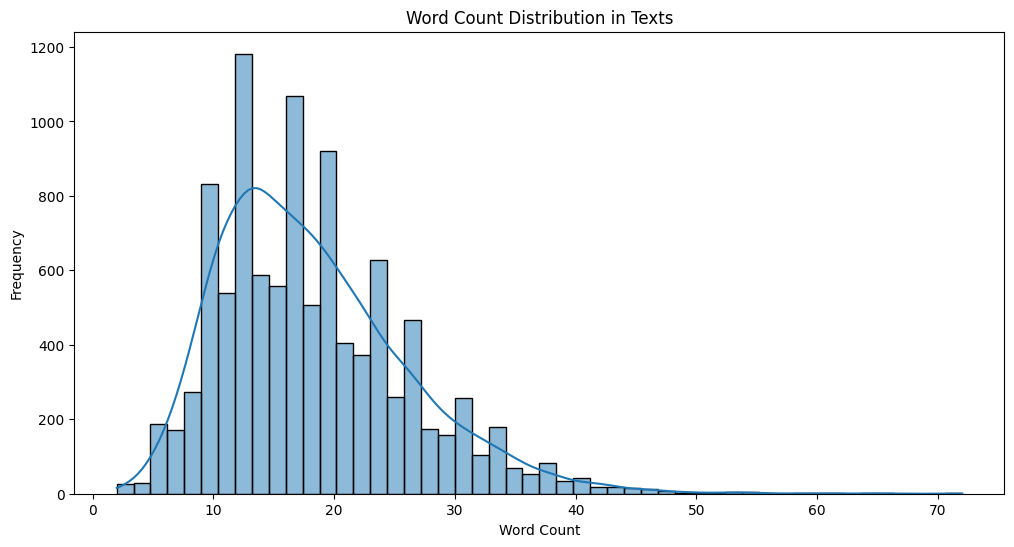

In [11]:
plot_word_count_distribution(liar_df, "Statement")

The "Word Count Distribution in Texts" plot displays the frequency of texts with a given word count, and we can interpret the following:

1. **Most Common Word Count**: The majority of texts have word counts in the range of approximately 10 to 20 words. This peak suggests that the dataset largely consists of short statements or claims, which is typical for datasets comprised of headlines or short excerpts.

2. **Skewness**: The distribution is right-skewed, meaning there are fewer texts with a very high word count. This indicates that while most of the news items are concise, there are some that are considerably longer.

3. **Potential Outliers**: The tail of the distribution, where the word count is above 40, suggests there are potential outliers in the dataset. These could be longer articles or detailed statements.

4. **Text Length Considerations for ML Models**: Short texts may not provide enough context for certain machine learning models to accurately classify them, and longer texts could introduce noise. It's important to consider the impact of text length when designing features and choosing or training models.

5. **Preprocessing and Feature Engineering**: The skewness in word count might motivate different text preprocessing strategies. For example, padding might be necessary for models that expect input of a uniform length, or truncation might be applied to very long texts to maintain computational efficiency.

6. **Dataset Representation**: The word count distribution can also inform about the representativeness of the dataset. If the dataset is intended to represent a variety of news items, the model might be biased towards understanding and classifying shorter texts better than longer ones.

In conclusion, this plot suggests that any machine learning model we develop will need to handle a wide range of text lengths, with a focus on shorter texts due to their prevalence in the dataset. We might also need to consider special treatment for the longer texts to ensure that they are not treated as outliers by the model. Additionally, the skewness of the distribution could affect the model's ability to generalize across texts of varying lengths.

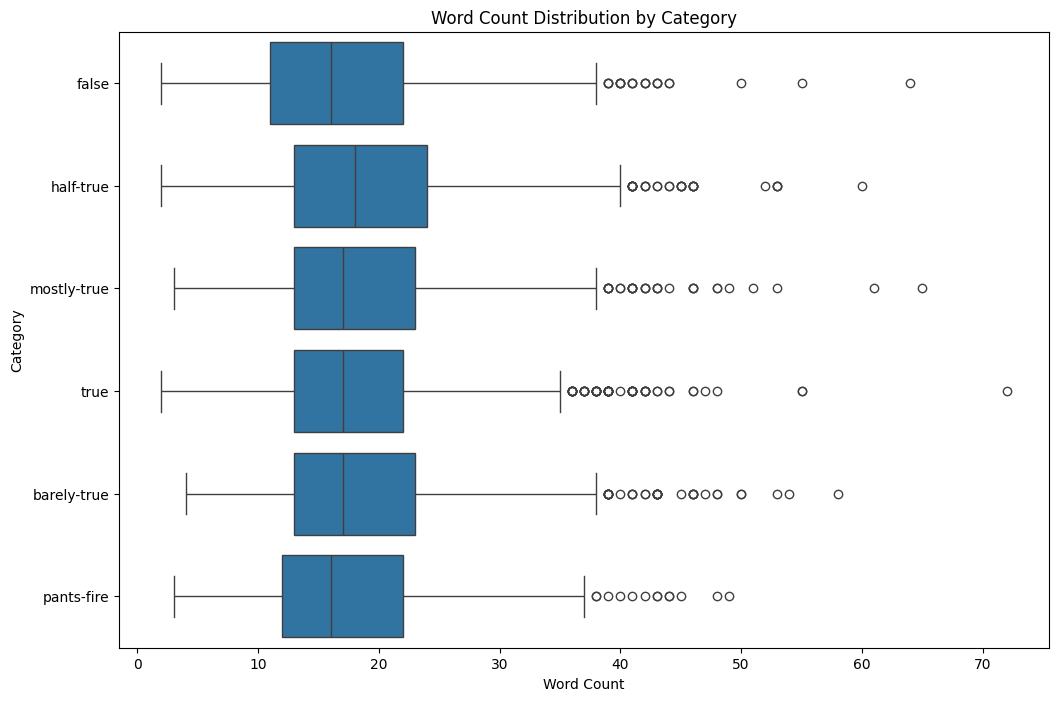

In [13]:
plot_word_count_by_category(liar_df, "Statement", "Label")

The "Word Count Distribution by Category" plot can tell us the following:

1. **Central Tendency and Spread**: Each box plot shows the median word count (the line inside the box), the interquartile range (the box itself), and the range (the "whiskers" extending from the box). This provides a clear view of the central tendency and variability within each category.

2. **Consistency Across Categories**: The median word counts across categories appear to be somewhat consistent, suggesting that the average length of text does not vary dramatically between different truthfulness categories.

3. **Outliers**: There are a number of outliers in each category, represented by the dots outside the whiskers. These indicate texts that are significantly longer than the majority within their respective categories.

4. **Comparison of Extremes**: The "pants-fire" category (which represents a clear falsehood) does not show a significantly different word count distribution from the other categories, indicating that the length of a statement or article is not necessarily an indicator of its truthfulness.

5. **Model Feature Engineering**: When engineering features for the machine learning model, this plot suggests that the word count feature might not be a strong discriminator on its own between truthfulness categories. However, it may still provide useful information when combined with other features.

While there is variation in text length within each category, the central tendency is quite consistent across categories. Outliers are present in all categories, which is an important consideration for model training. The word count alone may not be a strong feature for predicting truthfulness, but it could be part of a suite of features that, when combined, contribute to a more accurate model.

This preliminary exploratory data analysis has provided us with valuable insights into the structure and composition of the dataset, which is critical for developing an effective machine learning model for classifying news as fake or real. Through visual examination of the data, we have uncovered several potential caveats that need to be addressed during the data preparation phase.

Firstly, the class imbalance highlighted by the category distribution plot is a key concern. It has shed light on the skewed nature of the dataset, with certain truthfulness categories being overrepresented and others underrepresented. This imbalance can lead to biased model predictions, and we will need strategies like resampling or using class weights during model training to ensure each category is appropriately represented.

The word count distribution analysis has revealed the variance in the length of texts across the dataset. The predominance of shorter texts and the presence of outliers suggest that the predictive model will need to handle a wide range of input lengths. This influences preprocessing decisions, such as whether to pad shorter texts or truncate longer ones, and it also has implications for feature engineering, particularly in the choice of using word or character n-grams.

Let us now proceed with the next step - text processing.

## 3. Text Preprocessing

Now that we know how the data looks like - we can proceed with the next steps. We will employ the default NLP technics to cleanup our text:

1. **Tokenization**: refers to breaking the unstructured text into pieces of information that can be considered as discrete elements - tokens.
2. **Punctuation removal**: there are cases where punctuation can indicate some interesting features in the text, but in the context of our research it is not necessary. 
3. **Lower case**: to avoid having the same words written in different cases counted as separate words it is a good practice to normalize the case throughout the entire text.
4. **Numbers conversion**: we will convert all the numbers into words to preserve the meaning.
5. **Stop Words Removal**: since a lot of words are not carrying significant meaning in the sentence - they can be considered as noise and removed. Sometimes it is a good idea to extend the list of stop words, however, in our case the data describes very different events, so we will use the standard list. 
6. **Stemming**: it is a process of reducing the words to its root. The main purpose of stemming is to reduce the frequency of derived words.

We already have `word_tokenize` and `remove_punctuation` functions, let us define the missing functions.

In [45]:
def convert_lower_case(data):
    return [word.lower() for word in data]

def convert_numbers(data):
    new_data = []
    for word in data:
        # Remove commas and other punctuation from the word to check if it's a number
        stripped_word = re.sub(r'[^\w\s]', '', word)
        if stripped_word.isdigit():
            # Convert to word using num2words, then replace the original word in the list
            word = num2words(int(stripped_word))
        new_data.append(word)
    return new_data


def remove_stop_words(data):
    stop_words = set(stopwords.words('english'))
    return [word for word in data if word not in stop_words]

def stemming(data):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in data]

Our processing pipeline now looks like this:

In [42]:
def preprocess(data):
    data = remove_punctuation(data)
    data = word_tokenize(data)
    data = convert_lower_case(data)
    data = convert_numbers(data)
    data = remove_stop_words(data)
    data = stemming(data)

    return data

Let us try to process a piece of text to make sure we didn't miss anything.

In [34]:
liar_df.iloc[23]["Statement"]

'Says Scott Walker favors cutting up to 350,000 families and children off health care'

In [47]:
preprocess(liar_df.iloc[23]["Statement"])

['say',
 'scott',
 'walker',
 'favor',
 'cut',
 'three hundred and fifty thousand',
 'famili',
 'children',
 'health',
 'care']

Everything seems to be working correctly. Now we can move on to the next step - Feature engineering.

## 4. Feature Engineering

### 4.1 TF-IDF
TF-IDF is useful for determining the importance of a word in a document relative to a collection of documents. It helps identify significant terms in a document, which can then be used for classification or similarity scoring. Fake news often contains certain distinctive terms or phrases that can be detected using TF-IDF.

"we selected less but effective features which includes: number of words, number of characters, number of sentences, average word length, average sentence length and Name Entity recognition-based features. For NER feature, we extracted the following information from the text: person, org, date, time, FAC (airports, buildings etc.), GPE (countries, cities etc.), product, work of art (book titles, song titles etc.), language, money and cardinal." from [this article](https://www.sciencedirect.com/science/article/pii/S0167739X20330466?casa_token=hadEvpdcI4UAAAAA:3xXJTOIJ8qbp0mqKWehCl_agAtxV-1iqSH3jmm8ER4cSOvZ5kWEfXJ38xKBwigR1W5RZUp1F1Kg)